# Probability callibration

#### 0. Imports

In [64]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("..")
from src.support.data_transformation import TickerExtender, TechnicalIndicators, FileHandler
from src.support.model_evaluation import(
                                long_series_exog_to_dict, 
                                evaluate_recursive_multiseries, 
                                plot_interval_coverage)



from src.support.trade_evaluation import(
                                create_backtesting_df,
                                calculate_outcome_n_end_price,
                                aggregate_outcome_by_trade_id,
                                calculate_pnl_pct,
                                define_risk_rewards,
                                compute_all_metrics,
                                backtest_strategy,
                                plot_strategy_vs_ticker,
                                buy_hold_stock_performance_metrics)

from src.support.data_visualization import plot_bar_labels

ticker_extender = TickerExtender()

from skforecast.preprocessing import series_long_to_dict, exog_long_to_dict

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np

from typing import Dict

import warnings
from skforecast.exceptions.exceptions import MissingValuesWarning
warnings.simplefilter('ignore', category=MissingValuesWarning)

from sklearn.ensemble import HistGradientBoostingRegressor
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries



from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import matplotlib.pyplot as plt
seed = 8523

from skforecast.plot import plot_residuals

import os
from pathlib import Path

import seaborn as sns

base_dir = Path(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction to this notebook

The purpose of this notebook is to perform the probability interval forecast and evaluate the difference in nominal vs empirical coverage for the intervals.

# 2. Probability interval forecast

To create probability intervals with the multiseries recursive forcaster, it is necessary to perform bootstrapping. Other forecasters from Skforecast allow for better methods to estimate the intervals, like the direct forcaster. However, the direct forecaster did not perform any better than the recursive multiseries, while taking a lot longer to train and forcing to create one model per ticker. Therefore, as a first approach, bootstrapping intervals are used and the other methods remain for next steps.

## 2.1 Out-of-sample residuals

Bootstrapping intervals are based on the estimation of residuals distribution for the point forecast. Two types of residuals can be used:
- In-sample residuals. Residuals from the training set.
- Out-of-sample residuals. Residuals generated from unseen data.

The in-sample residuals tend to underestimate prediction uncertainty, because the model is optimized to fit training data as close as possible. Thus, out-of-sample residuals are preferred, as they represent better the true uncertainty of the data. To do so, it is necessary to get validation set predicitions from backtesting and then obtain the errors with the true values.

Import the dataset with the engineered features from the model evaluation notebook:

In [5]:
print("Enriching ticker dataframes.")
ticker_df_list = ticker_extender.transform_daily_tickers_parallel_experiment("../data/extracted/OHLCV",forecast_horizon=5)
print("Merging into one collection.")
merged_df_with_tech_ind = ticker_extender.merge_tickers(ticker_df_list)
del ticker_df_list

Enriching ticker dataframes.


Merging into one collection.


Retain only necessary columns

In [24]:
data_long_indicators = merged_df_with_tech_ind.select(pl.exclude(["high","low","open","volume","currency","region"])).filter(pl.col("datetime") >= datetime(2012,6,1)).filter(pl.col("symbol") != "LICI.NS") #.filter(pl.col("symbol").is_in(group_dict["group_1"]))

data_long_indicators_series = data_long_indicators.select(["datetime","close","symbol"])
data_long_indicators_exog = data_long_indicators.select(pl.exclude("close"))

# Keep only the top features selected in the modelling notebook
exog_selected = ["datetime","symbol","country","industry", "sector", 'growth_adj_365d_lagged_5', 'SMA22_lagged_5', '30d_volatility_lagged_5', 
                                                'volume_last_10_lagged_5', 'pct_3_month_high_lagged_5', 'pct_1_year_high_lagged_5', 'pct_6_month_low_lagged_5', 
                                                '10_day_rolling_return_lagged_5', '22_day_rolling_return_lagged_5', '126_day_rolling_return_lagged_5', '66_day_rolling_sharpe_lagged_5', 
                                                'autocorrelation_lag_1_lagged_5', 'autocorrelation_lag_6_lagged_5', 'rolling_skew_5_lagged_5', 'rolling_skew_10_lagged_5', 'rolling_skew_15_lagged_5']

data_long_indicators_exog = data_long_indicators_exog.select(exog_selected)

Create the train, val, test partitions in dictionary format

In [25]:
start_train = "2012-06-04" # Monday
end_train = '2021-07-02' # Friday
end_val = '2023-07-07' # Friday
start_test = '2023-07-07' # Monday
end_test = '2025-01-17' # Friday

series_dict_val, exog_dict_val, series_dict_train, exog_dict_train, _ = long_series_exog_to_dict(dataframe = data_long_indicators_series.to_pandas(),
                                series_id_column = "symbol", 
                                start_train = start_train,
                                end_train = end_train,
                                start_test = start_train,
                                end_test = end_val,
                                exog_dataframe = data_long_indicators_exog.to_pandas(),
                                index_freq = "B",
                                fill_nan = "ffill",
                                partition_name="Train",
                                verbose = False)

series_dict_test, exog_dict_test, _, _, _= long_series_exog_to_dict(dataframe = data_long_indicators_series.to_pandas(),
                                series_id_column = "symbol", 
                                start_train = start_train,
                                end_train = end_val,
                                start_test = start_test,
                                end_test = end_test,
                                exog_dataframe = data_long_indicators_exog.to_pandas(),
                                index_freq = "B",
                                fill_nan = "ffill",
                                partition_name="Validation",
                                verbose = False)

Train the model to backtest it on validation set data to contrast predictions against true values and obtain the residuals.

In [ ]:
# One hot encoder for categorical columns
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number)
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

# Hist gradient boosting with best parameters
best_params = {'max_iter': 200, 'max_depth': 8, 'learning_rate': 0.01383, 'min_samples_leaf': 7, 'max_leaf_nodes': 23, 'l2_regularization': 0.4322324323818845, 'max_bins': 171, 'early_stopping': True}
histb = HistGradientBoostingRegressor(random_state = seed, loss="quantile", quantile=0.5, **best_params)

# Train the model
params = {
    "series_train": series_dict_train,
    "series": series_dict_val,
    "model": histb,
    "forecast_horizon": 5,
    "exog_train": exog_dict_train,
    "exog": exog_dict_val,
    "window_stats": ["ratio_min_max","mean","mean"],
    "window_sizes": [2,5,15],
    "lags": [1,6, 9],
    "differentiation": 1,
    "transformer_exog": one_hot_encoder,
    "n_jobs": 1,
    "refit": 24,
    "encoding": "onehot",
    "fixed_train_size": True,
    "suppress_warnings": False,
    "show_progress": True,
    "verbose": False
}

metrics_levels, backtest_predictions, forecaster_recursive = evaluate_recursive_multiseries(**params)

With the model trained, we can briefly analyse the results before jumping into generating the intervals. Let's take the examples of LLY and AAPL:

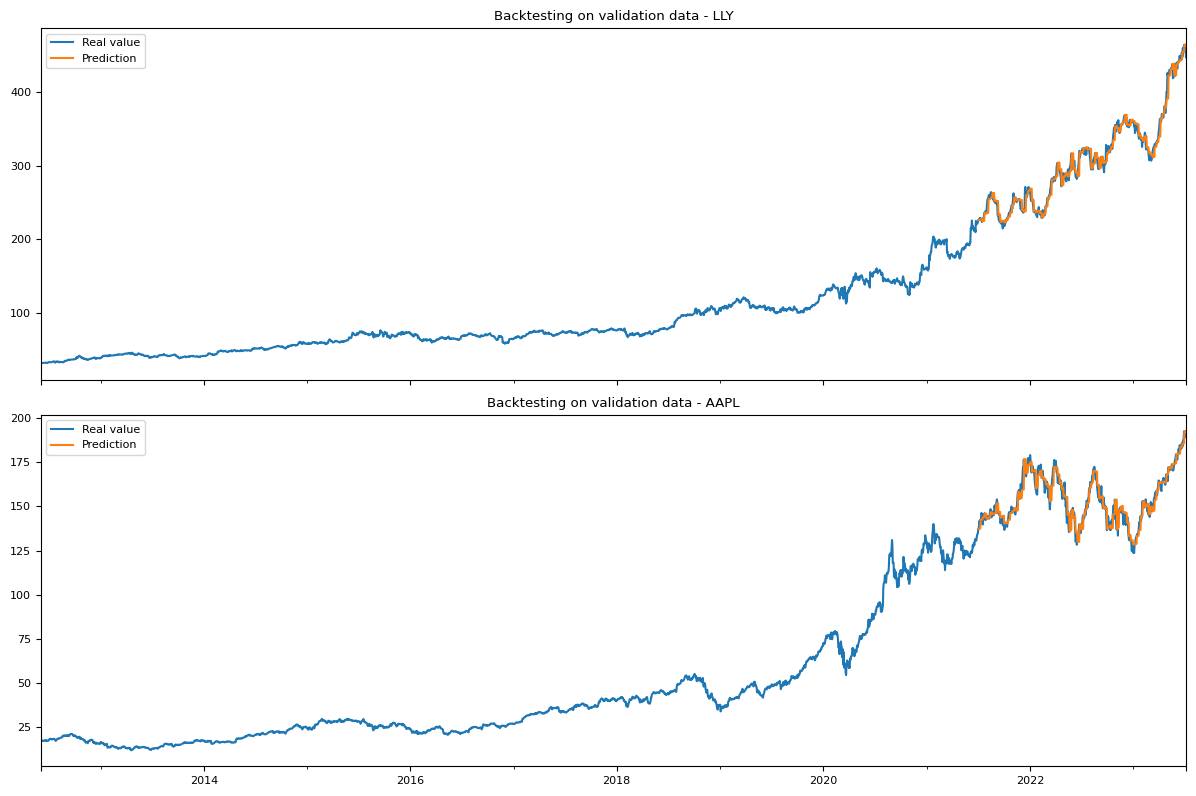

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# LLY subplot
series_dict_val["LLY"].plot(ax=axes[0], label='Real value')
backtest_predictions["LLY"].plot(ax=axes[0], label='Prediction')
axes[0].set_title("Backtesting on validation data - LLY")
axes[0].legend()

# AAPL subplot
series_dict_val["AAPL"].plot(ax=axes[1], label='Real value')
backtest_predictions["AAPL"].plot(ax=axes[1], label='Prediction')
axes[1].set_title("Backtesting on validation data - AAPL")
axes[1].legend()

plt.tight_layout()
plt.show()


LLY seems to have fitted best its predictions, while AAPL looks a bit more off. Let's observe the distributions of their residuals:

negative    264
positive    261
Name: count, dtype: int64


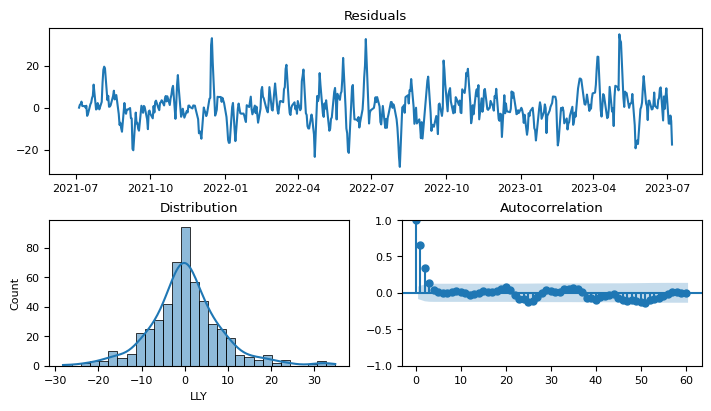

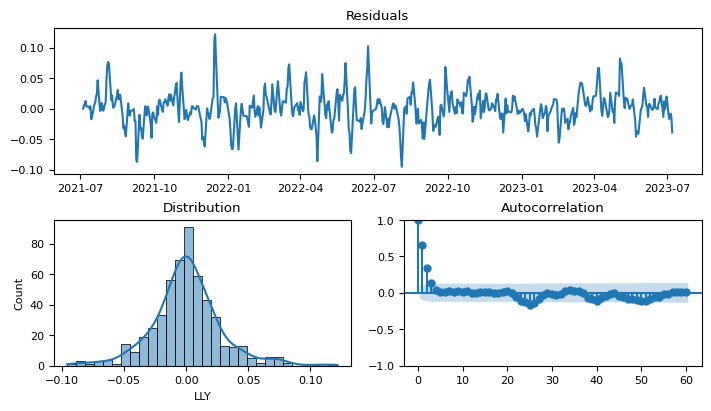

In [36]:
# Out-sample residuals distribution
# ==============================================================================
residuals = (series_dict_val["LLY"].loc[backtest_predictions["LLY"].index] - backtest_predictions["LLY"])
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))
_ = plot_residuals(residuals=residuals / series_dict_val["LLY"].loc[backtest_predictions["LLY"].index], figsize=(7, 4)) # divided by the original price 

The residuals for LLY follow a seemingly normal distribution, although with some heavy right tails. Additionally they show a strong sort term autocorrelation for lags up to 3 that the model does not seem to be capturing and also a group of sigificant correlations around lag 25. 

Let's check the residuals for AAPL:

negative    265
positive    260
Name: count, dtype: int64


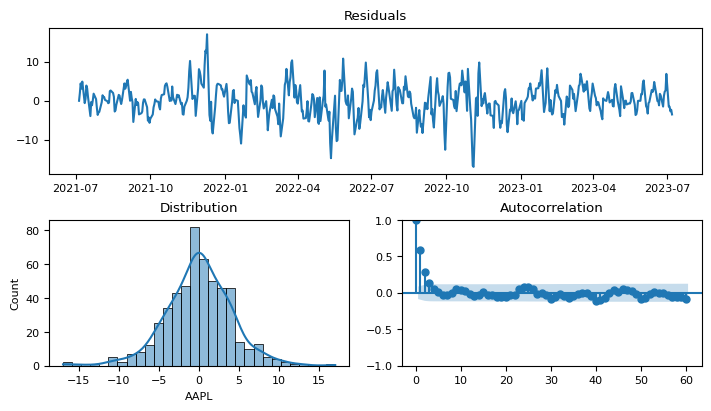

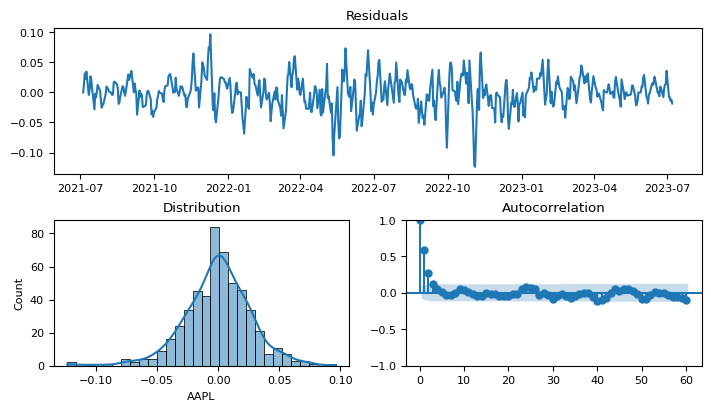

In [38]:
# Out-sample residuals distribution
# ==============================================================================
residuals = (series_dict_val["AAPL"].loc[backtest_predictions["AAPL"].index] - backtest_predictions["AAPL"])
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))
_ = plot_residuals(residuals=residuals / series_dict_val["AAPL"].loc[backtest_predictions["AAPL"].index], figsize=(7, 4)) # divided by the original price 

AAPL's residuals look a bit more off

Now, let's store residuals in the forecaster so it can use the out-of-sample residuals just calculated.

In [15]:
# Store out-sample residuals in the forecaster
# ==============================================================================
y_true_dict = {symbol: series_dict_val[symbol].loc[backtest_predictions.index] for symbol in series_dict_val.keys()}
y_pred_dict = {symbol: backtest_predictions[symbol] for symbol in series_dict_val.keys()}

forecaster_recursive.set_out_sample_residuals(
    y_true = y_true_dict,
    y_pred = y_pred_dict
) 

With the residuals now in the forecaster, it is possible to backtest again to assess the real coverage of prediction intervals. Let's start by a 50% nominal coverage:

In [ ]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 5, 
         initial_train_size = len(series_dict_val["AAPL"]),
         refit              = 1,
         differentiation = 1
     )

metrics_levels_bootstrap_50, backtest_predictions_bootstrap_50 = backtesting_forecaster_multiseries(
    forecaster            = forecaster_recursive,
    series                = series_dict_test,
    exog                  = exog_dict_test,
    cv                    = cv,
    interval              = [25, 75],  # between 25 and 75, 50% prediction interval
    n_boot                = 1000,
    metric                = "mean_absolute_percentage_error",
    add_aggregated_metric = False,
    n_jobs                = 6,
    verbose               = False,
    show_progress         = True,
    suppress_warnings     = False,
    use_in_sample_residuals = False
)

backtest_predictions_bootstrap_50.head(5)

Save backtest predictions for later reuse.

In [ ]:
pl.from_pandas(backtest_predictions_bootstrap_50).write_parquet(base_dir / "../data/predictions/backtest_predictions_bootstrap_50.parquet")

Inpect the results of real coverage out of the 50% nominal coverage designated:

In [ ]:
zoom_start = '2023-07-17'
zoom_end = '2024-12-31'
coverages = []
areas = []

for symbol in series_dict_test.keys():
    print("\n")
    print(f"Coverage for {symbol}:")
    coverage, area = plot_interval_coverage(interval_predictions = backtest_predictions_bootstrap_50,
                        series_dict_true = series_dict_test,
                        symbol=symbol,
                        zoom_start = zoom_start,
                        zoom_end = zoom_end
                        )
    coverages.append(coverage)
    areas.append(area)
    print("\n\n")
    print("================================================")
    
coverages_50 = pd.DataFrame({
    "symbol": series_dict_test.keys(),
    "nominal_coverage": [50]*len(coverages),
    "empirical_coverage": coverages,
    "area": areas
})
pl.from_pandas(coverages_50).write_parquet(base_dir / "../data/predictions/coverages_50.parquet")

Most residuals are way beyond the desired 50% mark. This means that the uncertainty expected by older residuals is bigger than that of the test set. We will later see if this bigger coverage is beneficial or not.

It seems that the empirical coverage is higher than the nominal coverage by around a 1.5 factor. Therefore, to obtain a 50% empirical coverage let's try to predict with a 35% nominal coverage interval.

In [ ]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 5, 
         initial_train_size = len(series_dict_val["AAPL"]),
         refit              = 1,
         differentiation = 1
     )

metrics_levels_bootstrap_35, backtest_predictions_bootstrap_35 = backtesting_forecaster_multiseries(
    forecaster            = forecaster_recursive,
    series                = series_dict_test,
    exog                  = exog_dict_test,
    cv                    = cv,
    interval              = [32.5, 67.5],  # between 25 and 75, 50% prediction interval
    n_boot                = 1000,
    metric                = "mean_absolute_percentage_error",
    add_aggregated_metric = False,
    n_jobs                = 6,
    verbose               = True,
    show_progress         = True,
    suppress_warnings     = False,
    use_in_sample_residuals = False
)

backtest_predictions_bootstrap_35.head(5)

Once again, let's save the results.

In [24]:
pl.from_pandas(backtest_predictions_bootstrap_35).write_parquet(base_dir / "../data/predictions/backtest_predictions_bootstrap_35.parquet")

Let's plot the results along with the metrics for true coverage from the nominal 35% coverage:

In [ ]:
zoom_start = '2023-07-17'
zoom_end = '2024-12-31'

coverages = []
areas = []

for symbol in series_dict_test.keys():
    print("\n")
    print(f"Coverage for {symbol}:")
    coverage, area = plot_interval_coverage(interval_predictions = backtest_predictions_bootstrap_35,
                        series_dict_true = series_dict_test,
                        symbol=symbol,
                        zoom_start = zoom_start,
                        zoom_end = zoom_end
                        )
    coverages.append(coverage)
    areas.append(area)
    print("\n\n")
    print("================================================")

coverages_35 = pd.DataFrame({
    "symbol": series_dict_test.keys(),
    "nominal_coverage": 35,
    "empirical_coverage": coverages,
    "area": areas})

pl.from_pandas(coverages_35).write_parquet(base_dir / "../data/predictions/coverages_35.parquet")

After this adjustment, we can see that some coverages achieve empirical 50% as intended, while some others achieve nominal levels, and others continue to be way off, around even 65%, which is more than double the nominal levels.

Let's head to the analysis of these intervals.

# 2. Interval trade analysis

The intervals calculated are intended to measure the uncertainty inherent to trading in the stocks market. The hypothesis is that, if we can have a true interval that represents **the statistical distribution or quantiles of errors**, then, we can establish limits which with enough trading oportunities, the stocks price will fall within. With that distribution around the mean prediction, the upper and lower bounds would allow us to determine the risk and reward ratio of each operation.

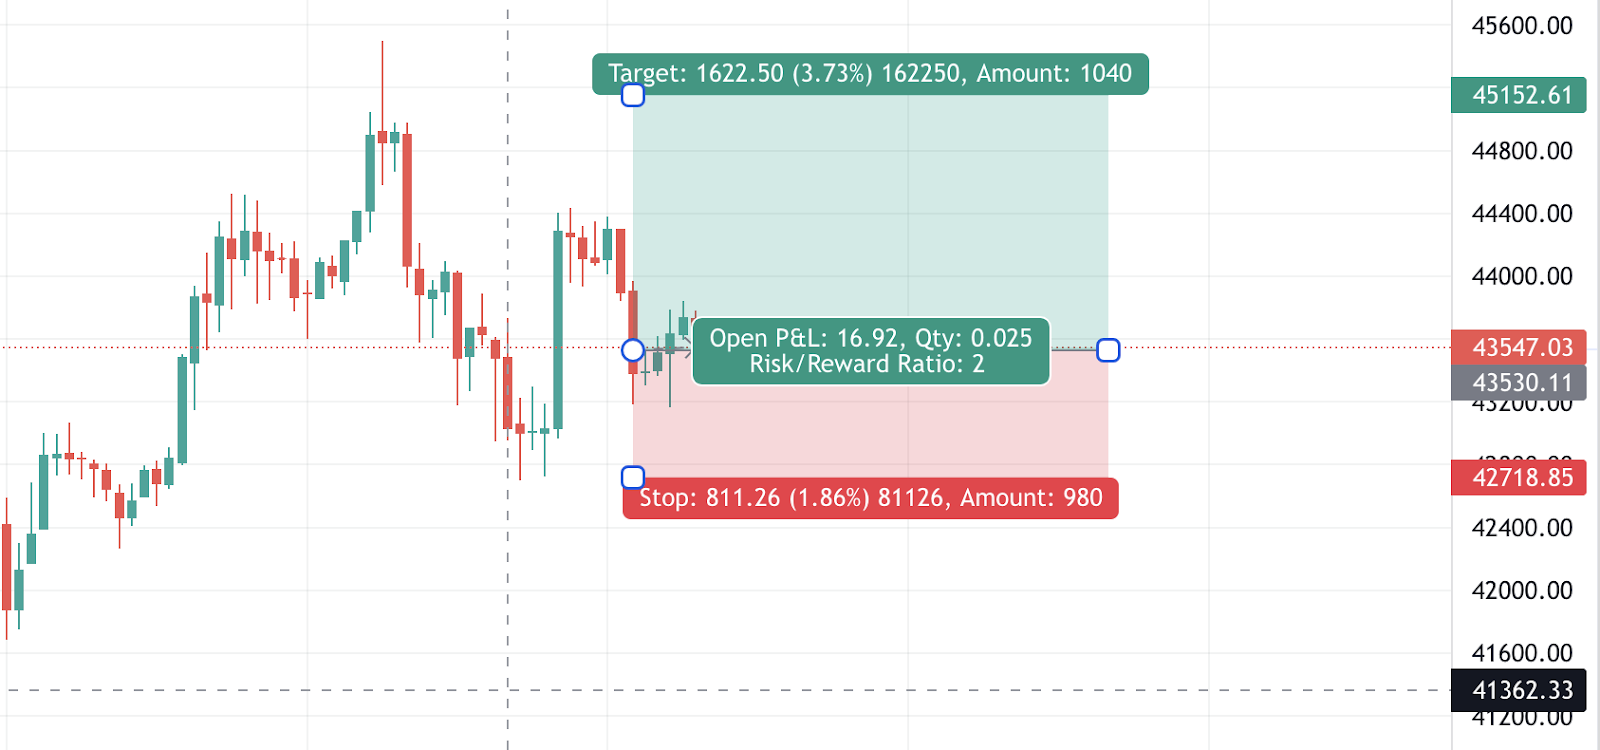

Now, that is an ideal that we will most possibly not attain. On one side, what we got is a bootstrapping approximation, not a true distribution of quantiles. On another, the empiric coverages differ quite a lot from the nominal and therefore, deviations are to be expected. Therefore, let's analyze the results of the intervals obtained and then perform backtesting simulations to see what out strategies performance would have been if they had got to market.

## 2.1 Analysis

Recover backtest predictions (in case of broken kernel or just visualization):

In [2]:
backtest_predictions_bootstrap_35 = pl.read_parquet(base_dir / "../data/predictions/backtest_predictions_bootstrap_35.parquet").with_columns(pl.Series("datetime",pd.bdate_range(start="2023-07-08", end="2025-01-17") ))
backtest_predictions_bootstrap_50 = pl.read_parquet(base_dir / "../data/predictions/backtest_predictions_bootstrap_50.parquet").with_columns(pl.Series("datetime",pd.bdate_range(start="2023-07-08", end="2025-01-17") ))

In [3]:
def plot_combined_target_distribution(df, target, feature, bins=25, repl_dict={}, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    fig.suptitle(f"Proportion of '{target}' by '{feature}' distribution")
    # Plot histogram without automatic legend
    sns.histplot(data=df,
                x=feature,
                bins=bins,
                ax=ax)

    # Create second axis
    ax2 = ax.twinx()

    sns.histplot(data=df,
             x=feature,
             hue=target,  # Differentiates by target status
             stat="probability",  # Normalize within bins
             bins=bins,  # Adjust number of bins as needed
             multiple="fill",  # Makes each bin stack to 1 (100%)
             palette={1: "red", 0: "#FFFFFF"},
             ax=ax2,
             alpha=0.3,
             edgecolor=None)


    # Set y-axis limits
    ax2.set_ylim(0, 1)

    # remov automatic ax2 legend
    ax2.get_legend().remove()

    # Add custom legend for both plots
    fig.legend([f"{feature.capitalize()} distribution", f"{target.capitalize()} proportion"], loc="upper right")

    plt.show()

Let's start by taking the backtesting prediction dataframes for the nominal 50 and nominal 35 coverage intervals.

In [6]:
# create backtesting analysis table
backtest_predictions_bootstrap_50_analysis = create_backtesting_df(backtest_predictions_bootstrap_50, merged_df_with_tech_ind.select(["datetime","symbol","open","high","close","low"]))
backtest_predictions_bootstrap_35_analysis = create_backtesting_df(backtest_predictions_bootstrap_35, merged_df_with_tech_ind.select(["datetime","symbol","open","high","close","low"]))

Let's calculate their supposed PnL %

In [71]:
backtest_50_pnl = calculate_pnl_pct( aggregate_outcome_by_trade_id( calculate_outcome_n_end_price( backtest_predictions_bootstrap_50_analysis)))
backtest_35_pnl = calculate_pnl_pct( aggregate_outcome_by_trade_id( calculate_outcome_n_end_price( backtest_predictions_bootstrap_35_analysis)))

And now add binary columns for trades that passed or not their Risk Reward ratio. 

In [34]:
rr_ratios_list = [1, 1.25, 1.5, 2, 2.5, 3, 3.5, 4]
backtest_50_pnl_rrr = define_risk_rewards(backtest_50_pnl, rr_ratios_list)
backtest_50_pnl_rrr.head()

shape: (5, 23)
┌──────────┬────────┬─────────┬────────────┬───┬───────────────┬──────────────┬──────────────┬─────┐
│ trade_id ┆ symbol ┆ outcome ┆ open_day_1 ┆ … ┆ >trade_3_rati ┆ >trade_3.5_r ┆ >trade_4_rat ┆ win │
│ ---      ┆ ---    ┆ ---     ┆ ---        ┆   ┆ o             ┆ atio         ┆ io           ┆ --- │
│ i64      ┆ str    ┆ str     ┆ f64        ┆   ┆ ---           ┆ ---          ┆ ---          ┆ i32 │
│          ┆        ┆         ┆            ┆   ┆ i32           ┆ i32          ┆ i32          ┆     │
╞══════════╪════════╪═════════╪════════════╪═══╪═══════════════╪══════════════╪══════════════╪═════╡
│ 0        ┆ AAPL   ┆ SL      ┆ 187.835899 ┆ … ┆ 0             ┆ 0            ┆ 0            ┆ 0   │
│ 1        ┆ ACN    ┆ TP      ┆ 298.058795 ┆ … ┆ 0             ┆ 0            ┆ 0            ┆ 1   │
│ 2        ┆ AMZN   ┆ SL      ┆ 129.070007 ┆ … ┆ 0             ┆ 0            ┆ 0            ┆ 0   │
│ 3        ┆ ASML   ┆ TP      ┆ 694.760147 ┆ … ┆ 0             ┆ 0            ┆ 0            ┆ 1   │
│ 4        ┆ AVGO   ┆ TP      ┆ 82.866189  ┆ … ┆ 0             ┆ 0            ┆ 0            ┆ 1   │
└──────────┴────────┴─────────┴────────────┴───┴───────────────┴──────────────┴──────────────┴─────┘

First, let's check the ranges of the features:

In [35]:
backtest_50_pnl_rrr.describe()

shape: (9, 24)
┌────────────┬────────────┬────────┬─────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ statistic  ┆ trade_id   ┆ symbol ┆ outcome ┆ … ┆ >trade_3_r ┆ >trade_3.5 ┆ >trade_4_r ┆ win      │
│ ---        ┆ ---        ┆ ---    ┆ ---     ┆   ┆ atio       ┆ _ratio     ┆ atio       ┆ ---      │
│ str        ┆ f64        ┆ str    ┆ str     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ f64      │
│            ┆            ┆        ┆         ┆   ┆ f64        ┆ f64        ┆ f64        ┆          │
╞════════════╪════════════╪════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ count      ┆ 2560.0     ┆ 2560   ┆ 2560    ┆ … ┆ 2560.0     ┆ 2560.0     ┆ 2560.0     ┆ 2560.0   │
│ null_count ┆ 0.0        ┆ 0      ┆ 0       ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ mean       ┆ 1279.5     ┆ null   ┆ null    ┆ … ┆ 0.055078   ┆ 0.039844   ┆ 0.030859   ┆ 0.492578 │
│ std        ┆ 739.152668 ┆ null   ┆ null    ┆ … ┆ 0.228177   ┆ 0.19563    ┆ 0.17297    ┆ 0.500043 │
│ min        ┆ 0.0        ┆ AAPL   ┆ SL      ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 25%        ┆ 640.0      ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 50%        ┆ 1280.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 75%        ┆ 1919.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 1.0      │
│ max        ┆ 2559.0     ┆ V      ┆ close   ┆ … ┆ 1.0        ┆ 1.0        ┆ 1.0        ┆ 1.0      │
└────────────┴────────────┴────────┴─────────┴───┴────────────┴────────────┴────────────┴──────────┘

There are some extreme RRR for both high and low values. Very negative values can stem from Open prices being below lower bounds, while very high positive values can be due to the lower bound being very close to the Open price. LEt's leave those out.

In [83]:
backtest_50_pnl_rrr_filtered = backtest_50_pnl_rrr.filter(pl.col("mean_RRR") >= 0, pl.col("mean_RRR") < 100)
backtest_50_pnl_rrr_filtered.describe()

shape: (9, 24)
┌────────────┬────────────┬────────┬─────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ statistic  ┆ trade_id   ┆ symbol ┆ outcome ┆ … ┆ >trade_3_r ┆ >trade_3.5 ┆ >trade_4_r ┆ win      │
│ ---        ┆ ---        ┆ ---    ┆ ---     ┆   ┆ atio       ┆ _ratio     ┆ atio       ┆ ---      │
│ str        ┆ f64        ┆ str    ┆ str     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ f64      │
│            ┆            ┆        ┆         ┆   ┆ f64        ┆ f64        ┆ f64        ┆          │
╞════════════╪════════════╪════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ count      ┆ 2283.0     ┆ 2283   ┆ 2283    ┆ … ┆ 2283.0     ┆ 2283.0     ┆ 2283.0     ┆ 2283.0   │
│ null_count ┆ 0.0        ┆ 0      ┆ 0       ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ mean       ┆ 1292.10074 ┆ null   ┆ null    ┆ … ┆ 0.060447   ┆ 0.043364   ┆ 0.03329    ┆ 0.533071 │
│            ┆ 5          ┆        ┆         ┆   ┆            ┆            ┆            ┆          │
│ std        ┆ 755.237705 ┆ null   ┆ null    ┆ … ┆ 0.238365   ┆ 0.20372    ┆ 0.179431   ┆ 0.499014 │
│ min        ┆ 0.0        ┆ AAPL   ┆ SL      ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 25%        ┆ 603.0      ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 50%        ┆ 1310.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 1.0      │
│ 75%        ┆ 1969.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 1.0      │
│ max        ┆ 2559.0     ┆ V      ┆ close   ┆ … ┆ 1.0        ┆ 1.0        ┆ 1.0        ┆ 1.0      │
└────────────┴────────────┴────────┴─────────┴───┴────────────┴────────────┴────────────┴──────────┘

Although not related to the strategy, below the rate of trades that would be winning if we played all.

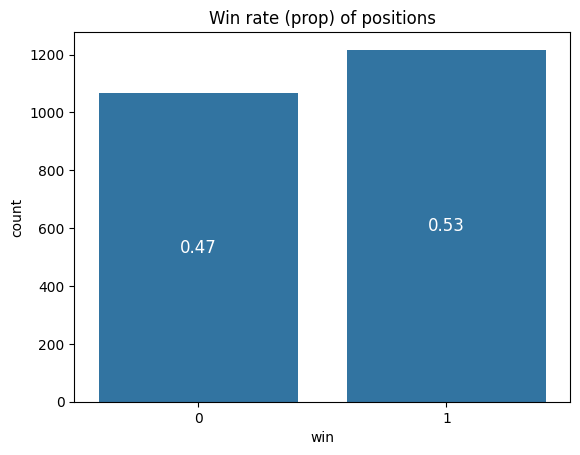

In [107]:
plt.title("Win rate (prop) of positions")
ax = sns.countplot(data=backtest_50_pnl_rrr_filtered, x="win")
plot_bar_labels(ax,  normalise = True) 

Now let's check if winning trades have, on average, higher RR that not winning ones.

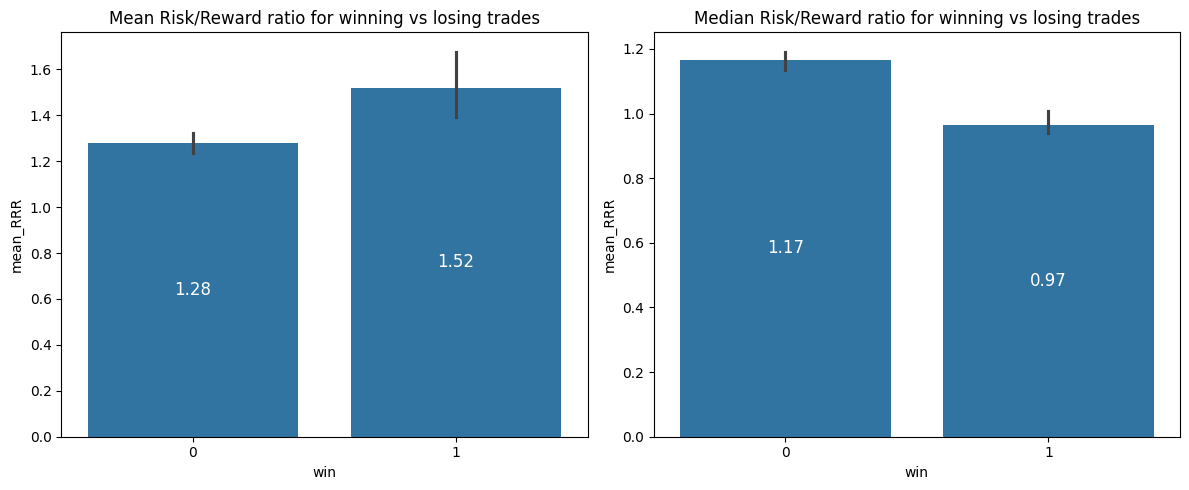

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean Risk/Reward ratio for winning vs losing trades")
sns.barplot(data=backtest_50_pnl_rrr_filtered, x="win", y="mean_RRR", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median Risk/Reward ratio for winning vs losing trades")
sns.barplot(data=backtest_50_pnl_rrr_filtered, x="win", y="mean_RRR", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()


As we can see, the difference in RRR means is not too big for winning trades. Checking the median RRR, we can see that winning trades do not tend to have high RRR actually. Let's plot the hued distribution of RRR for winning vs not winning trades:

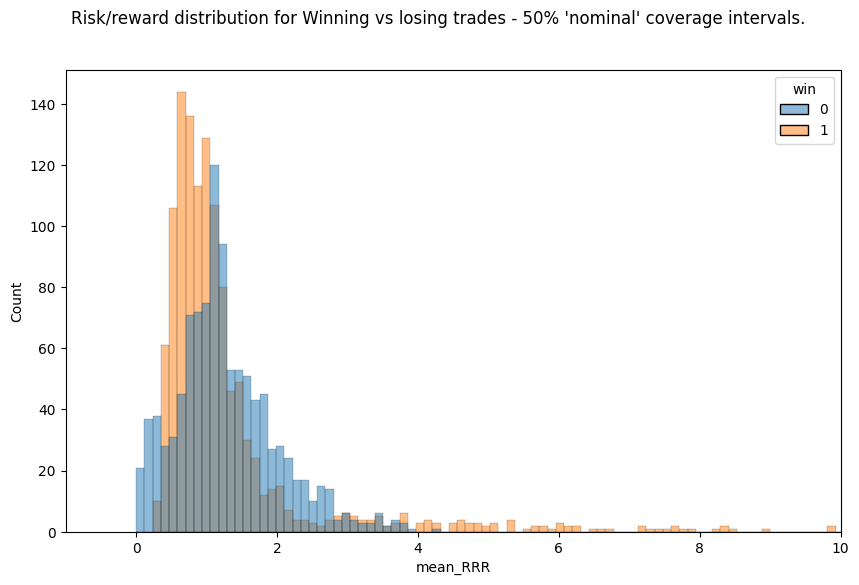

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Risk/reward distribution for Winning vs losing trades - 50% 'nominal' coverage intervals. ")

sns.histplot(data=backtest_50_pnl_rrr_filtered,
             x="mean_RRR",
             hue="win",
             ax=ax)

# Zoom into x-axis
ax.set_xlim(-1, 10)
plt.show()

It seems that the proportion of winning trades outweights that of losing ones starting around the 3 RRR mark. Let's see how the PnL % interacts with RRR there. 

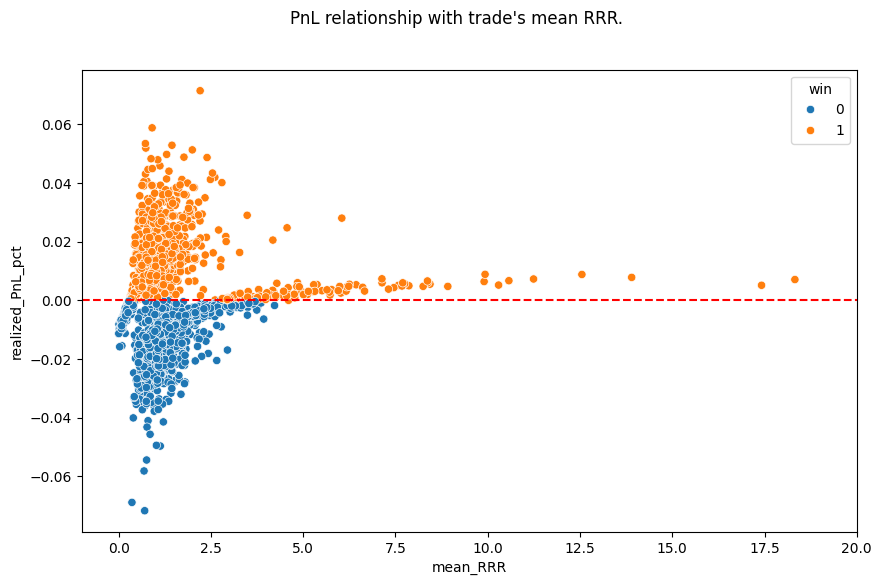

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("PnL relationship with trade's mean RRR.")

sns.scatterplot(data=backtest_50_pnl_rrr_filtered,
                x="mean_RRR",
                y="realized_PnL_pct",
                hue="win",
                ax=ax)

# Draw horizontal line at y=0
ax.axhline(y=0, color="red", linestyle="--", linewidth=1.5)

# Zoom into x-axis
ax.set_xlim(-1, 20)
plt.show()

What we can see is that, trades do effectively take off after the 4 RRR mark, where profits are more secured, but profits look to be below 1%. Let's see the numbers:

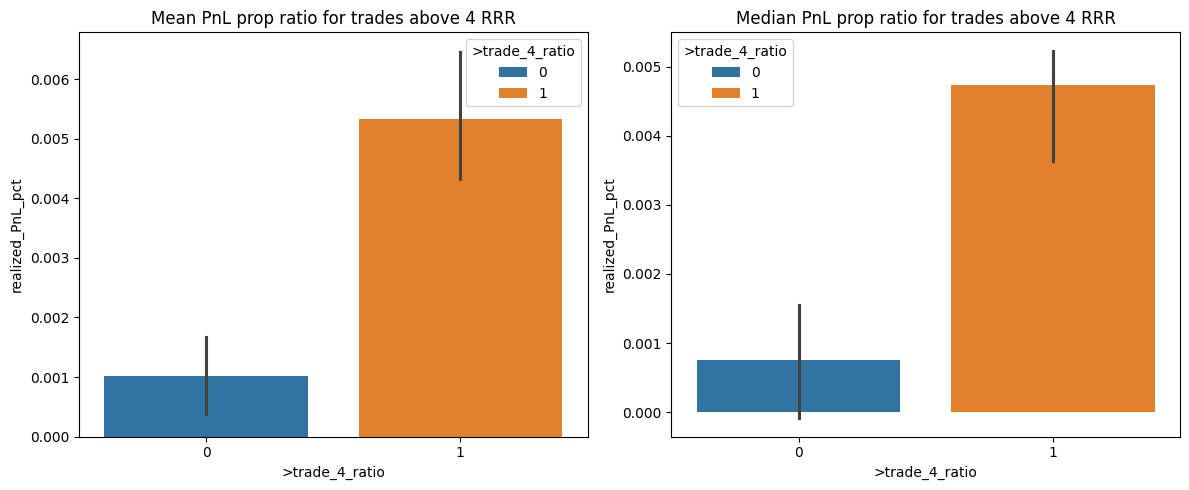

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean PnL prop ratio for trades above 4 RRR")
sns.barplot(data=backtest_50_pnl_rrr_filtered, x=">trade_4_ratio",hue=">trade_4_ratio", y="realized_PnL_pct", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median PnL prop ratio for trades above 4 RRR")
sns.barplot(data=backtest_50_pnl_rrr_filtered, x=">trade_4_ratio", hue=">trade_4_ratio", y="realized_PnL_pct", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()


Actually not bad. Mean profit for trades with RRR above 4 is 0.5%. There is also another edge that could be taken a look at, and that is the region of lower RRR, between 0.25 and 1.

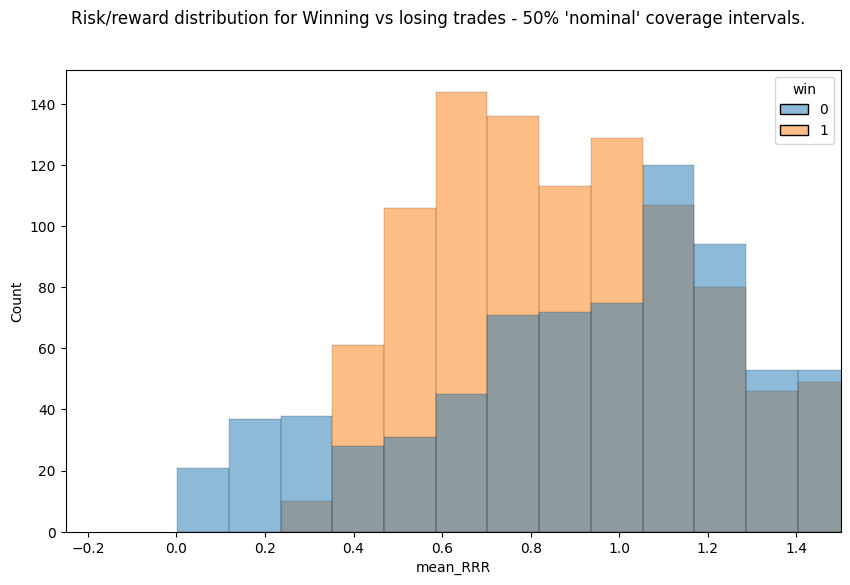

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Risk/reward distribution for Winning vs losing trades - 50% 'nominal' coverage intervals. ")

sns.histplot(data=backtest_50_pnl_rrr_filtered,
             x="mean_RRR",
             hue="win",
             ax=ax)

# Zoom into x-axis
ax.set_xlim(-0.25, 1.5)
plt.show()

More precisely, the region between 0.4 and 1 seems to have a higher frequency of wins than losses. 

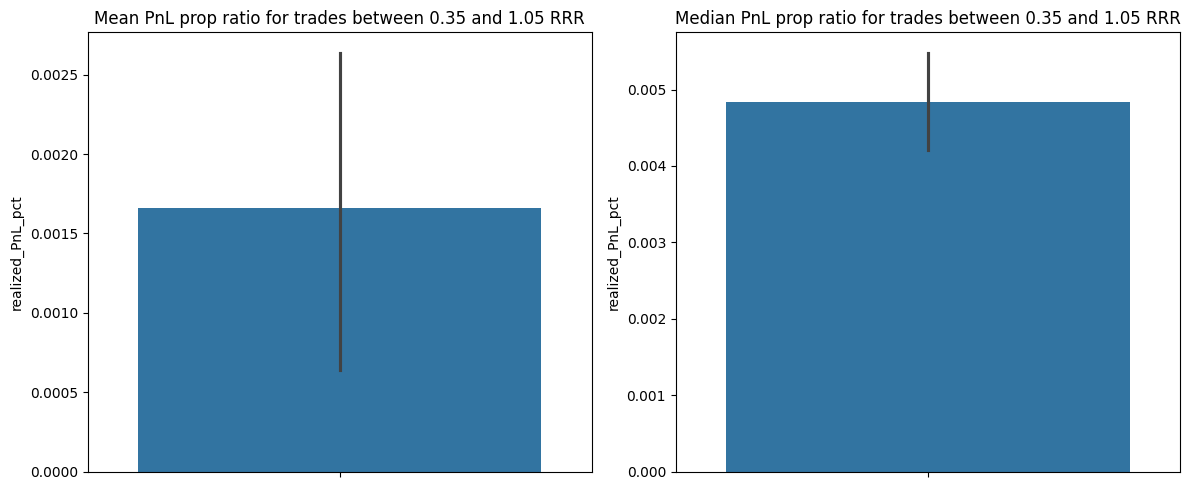

In [89]:
# Filter
backtest_50_pnl_rrr_between_0_35_and_1_05 = backtest_50_pnl_rrr.filter(pl.col("mean_RRR") >= 0.35, pl.col("mean_RRR") < 1.05)


# Plot
# ===============================================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean PnL prop ratio for trades between 0.35 and 1.05 RRR")
sns.barplot(data=backtest_50_pnl_rrr_between_0_35_and_1_05, y="realized_PnL_pct", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median PnL prop ratio for trades between 0.35 and 1.05 RRR")
sns.barplot(data=backtest_50_pnl_rrr_between_0_35_and_1_05, y="realized_PnL_pct", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()

Although wins are more frequent within the 0.35-1.05 range, the profitability there dies due to the neutralization of losing trades. The % profitability being 0.15%, it does not cover the commission rates by the majority of brokers.
Therefore, the only option would be to trade those >4_rr_ratio trades, for which during the 18 months that the test set lasts there is around one once a week:


In [68]:
backtest_50_pnl_rrr.group_by(">trade_4_ratio").len()

shape: (2, 2)
┌────────────────┬──────┐
│ >trade_4_ratio ┆ len  │
│ ---            ┆ ---  │
│ i32            ┆ u32  │
╞════════════════╪══════╡
│ 0              ┆ 2481 │
│ 1              ┆ 79   │
└────────────────┴──────┘

The **conclusion of this analysis** of the 50% nominal coverage is that, as suspected, probability intervals do not reflect the true distribution of residuals in the test set. Risk/Reward ratios in trading are used to established a minimum profitability to be acquired by trade with respect to a typical win rate, but in this study, theoretical Risk/Rewards are tied to 

Let's see how the 35% nominal coverage does.

In [73]:
rr_ratios_list = [1, 1.25, 1.5, 2, 2.5, 3, 3.5, 4]
backtest_35_pnl_rrr = define_risk_rewards(backtest_35_pnl, rr_ratios_list)
backtest_35_pnl_rrr.describe()

shape: (9, 24)
┌────────────┬────────────┬────────┬─────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ statistic  ┆ trade_id   ┆ symbol ┆ outcome ┆ … ┆ >trade_3_r ┆ >trade_3.5 ┆ >trade_4_r ┆ win      │
│ ---        ┆ ---        ┆ ---    ┆ ---     ┆   ┆ atio       ┆ _ratio     ┆ atio       ┆ ---      │
│ str        ┆ f64        ┆ str    ┆ str     ┆   ┆ ---        ┆ ---        ┆ ---        ┆ f64      │
│            ┆            ┆        ┆         ┆   ┆ f64        ┆ f64        ┆ f64        ┆          │
╞════════════╪════════════╪════════╪═════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ count      ┆ 2560.0     ┆ 2560   ┆ 2560    ┆ … ┆ 2560.0     ┆ 2560.0     ┆ 2560.0     ┆ 2560.0   │
│ null_count ┆ 0.0        ┆ 0      ┆ 0       ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ mean       ┆ 1279.5     ┆ null   ┆ null    ┆ … ┆ 0.102344   ┆ 0.078516   ┆ 0.065625   ┆ 0.511719 │
│ std        ┆ 739.152668 ┆ null   ┆ null    ┆ … ┆ 0.303159   ┆ 0.269034   ┆ 0.247674   ┆ 0.49996  │
│ min        ┆ 0.0        ┆ AAPL   ┆ SL      ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 25%        ┆ 640.0      ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0      │
│ 50%        ┆ 1280.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 1.0      │
│ 75%        ┆ 1919.0     ┆ null   ┆ null    ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 1.0      │
│ max        ┆ 2559.0     ┆ V      ┆ close   ┆ … ┆ 1.0        ┆ 1.0        ┆ 1.0        ┆ 1.0      │
└────────────┴────────────┴────────┴─────────┴───┴────────────┴────────────┴────────────┴──────────┘

Here we also find very extreme mean_RRR. This is probably due to intervals being more close together. Let's see the histplot to establish thresholds for a filter:

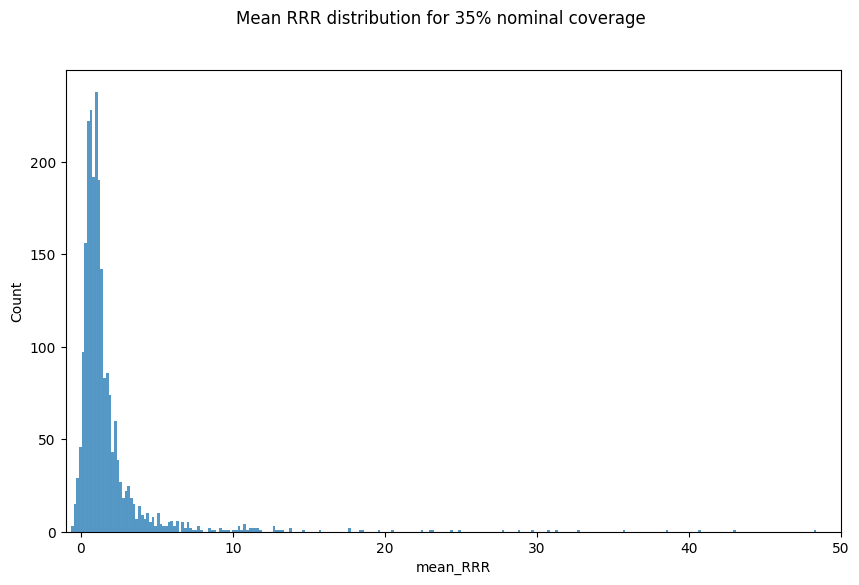

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Mean RRR distribution for 35% nominal coverage")

sns.histplot(data=backtest_35_pnl_rrr,
             x="mean_RRR",
             ax=ax)

# Zoom into x-axis
ax.set_xlim(-1, 50)
plt.show()

Leaving it to 100 for comparison with the previous 50% nominal coverage.

In [96]:
backtest_35_pnl_rrr_filtered = backtest_35_pnl_rrr.filter(pl.col("mean_RRR") >= 0, pl.col("mean_RRR") < 100)

Now, repeating the above analysis.

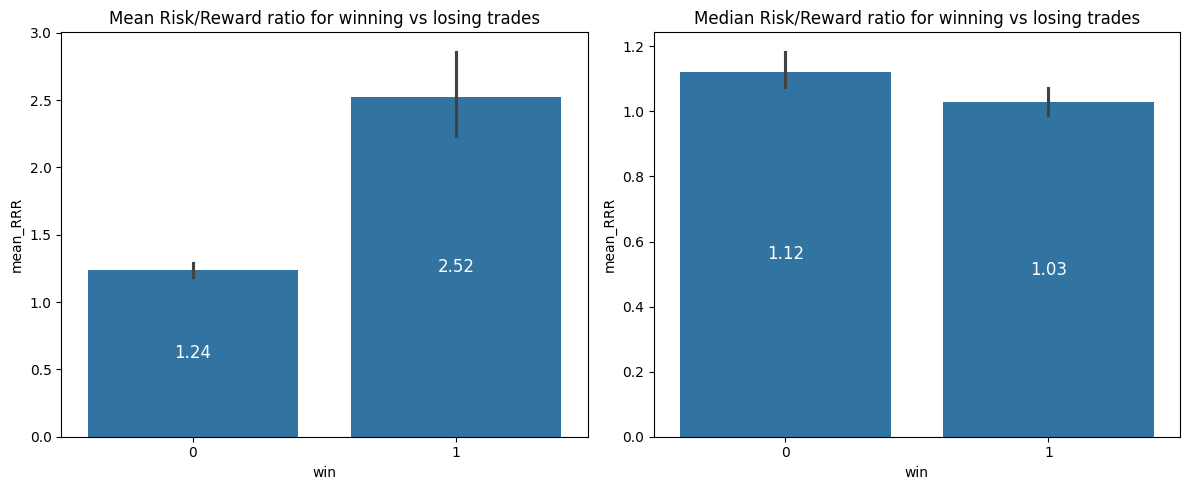

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean Risk/Reward ratio for winning vs losing trades")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x="win", y="mean_RRR", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median Risk/Reward ratio for winning vs losing trades")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x="win", y="mean_RRR", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()


Here, the mean difference of mean RRR for winning vs not winning trades is bigger, while the median mean_RRR continues to be below as with the 50% nominal coverage intervals.

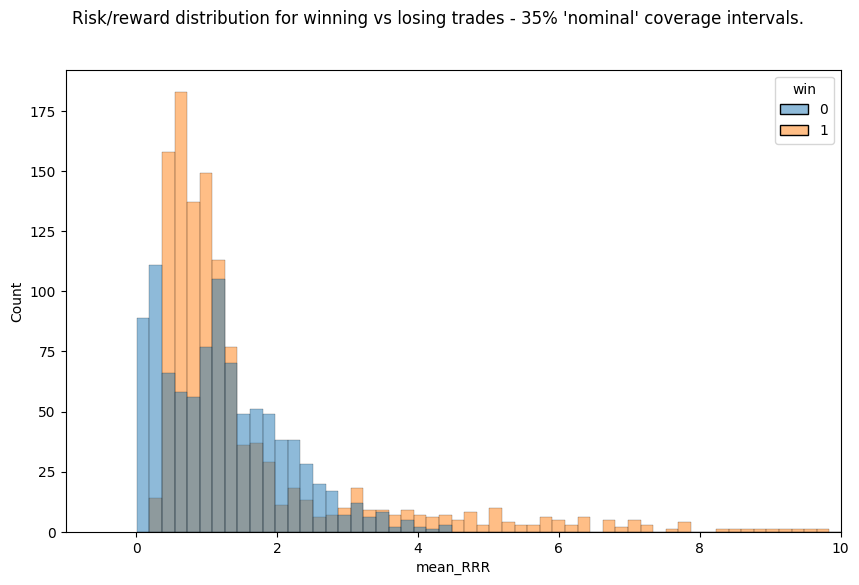

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Risk/reward distribution for winning vs losing trades - 35% 'nominal' coverage intervals. ")

sns.histplot(data=backtest_35_pnl_rrr_filtered,
             x="mean_RRR",
             hue="win",
             ax=ax)

# Zoom into x-axis
ax.set_xlim(-1, 10)
plt.show()

Similar to what happened before, there is a region around 0.3 an 1.2 of the mean RRR where there is a higher winning rate. Again, the win rate beyond the >4 mean RRR is practically 100%.

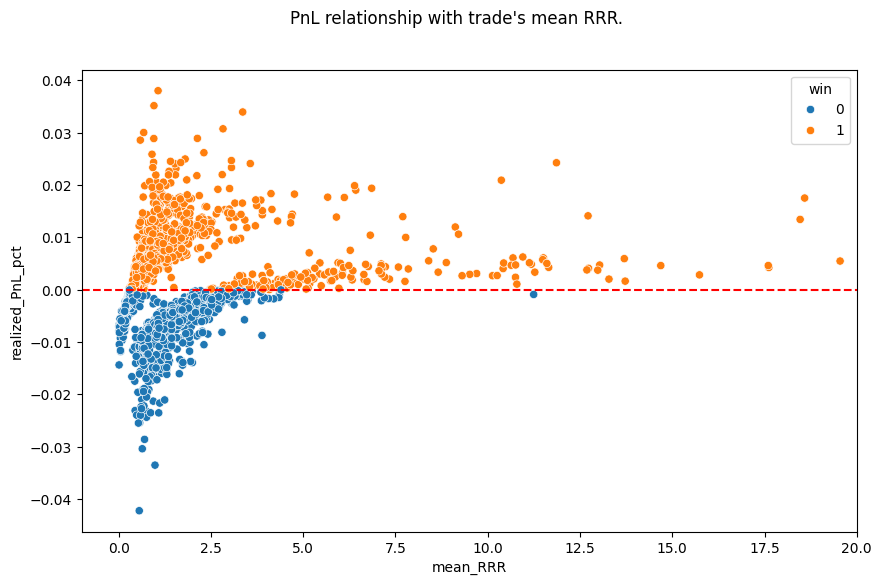

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("PnL relationship with trade's mean RRR.")

sns.scatterplot(data=backtest_35_pnl_rrr_filtered,
                x="mean_RRR",
                y="realized_PnL_pct",
                hue="win",
                ax=ax)

# Draw horizontal line at y=0
ax.axhline(y=0, color="red", linestyle="--", linewidth=1.5)

# Zoom into x-axis
ax.set_xlim(-1, 20)
plt.show()

Again, we see a diverging pattern, this time clearer, in the relationship between PnL and mean_RRR. 

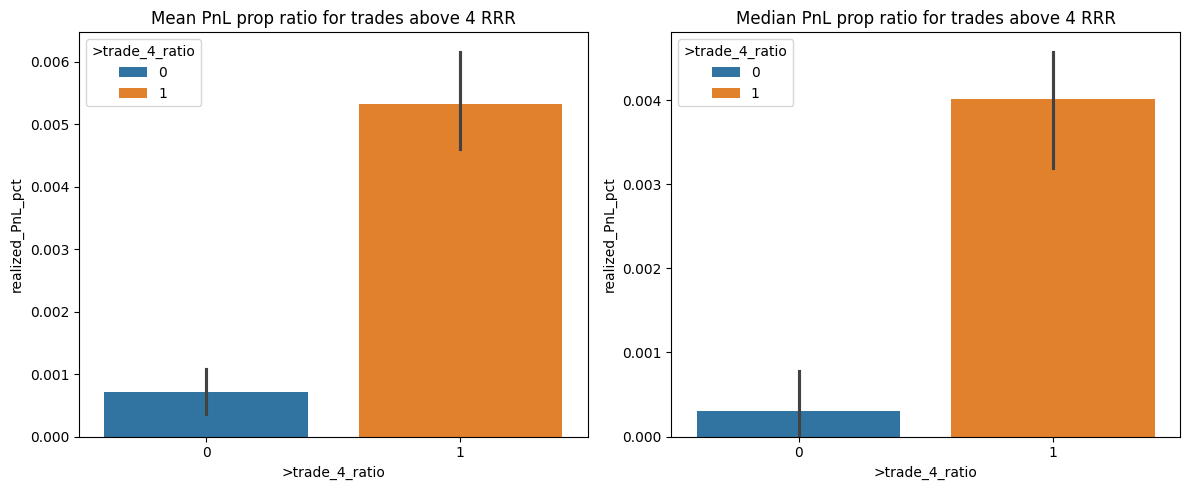

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean PnL prop ratio for trades above 4 RRR")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x=">trade_4_ratio",hue=">trade_4_ratio", y="realized_PnL_pct", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median PnL prop ratio for trades above 4 RRR")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x=">trade_4_ratio", hue=">trade_4_ratio", y="realized_PnL_pct", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()


Mean profit for trades with RRR above 4 is again around 0.5%, while for trades below it its even lower than before. In the previous chart it seemed that trades of around >3 RRR were very profitable too.


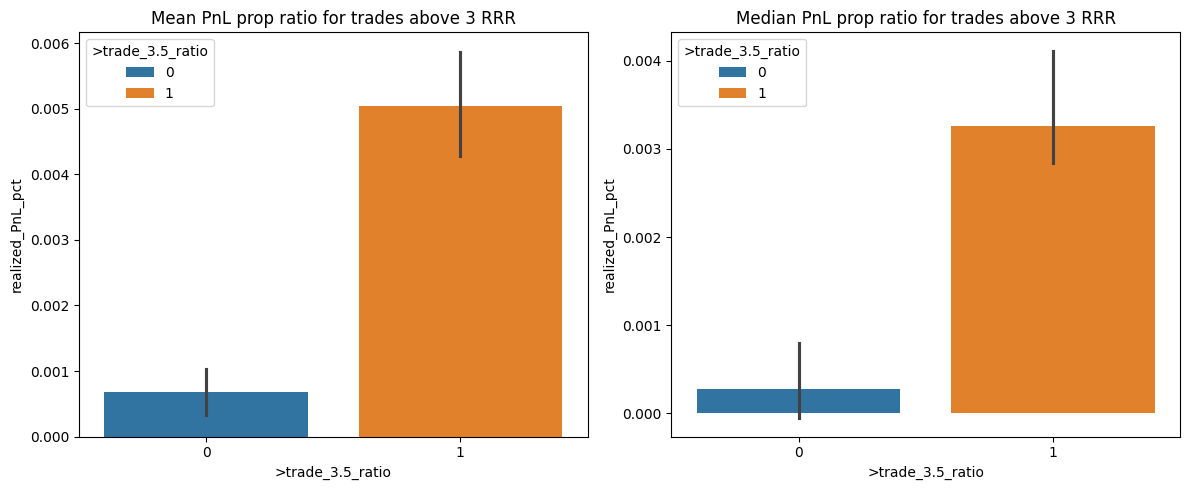

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean PnL prop ratio for trades above 3 RRR")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x=">trade_3.5_ratio",hue=">trade_3.5_ratio", y="realized_PnL_pct", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median PnL prop ratio for trades above 3 RRR")
sns.barplot(data=backtest_35_pnl_rrr_filtered, x=">trade_3.5_ratio", hue=">trade_3.5_ratio", y="realized_PnL_pct", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()

Mean profitability is maintained. While very probably increasing the number of tradeable operations.

In [127]:
display(backtest_35_pnl_rrr.group_by(">trade_4_ratio").agg(pl.col("realized_PnL_pct").mean(), pl.col("trade_id").count()))
display(backtest_35_pnl_rrr.group_by(">trade_3.5_ratio").agg(pl.col("realized_PnL_pct").mean(), pl.col("trade_id").count()))

shape: (2, 3)
┌────────────────┬──────────────────┬──────────┐
│ >trade_4_ratio ┆ realized_PnL_pct ┆ trade_id │
│ ---            ┆ ---              ┆ ---      │
│ i32            ┆ f64              ┆ u32      │
╞════════════════╪══════════════════╪══════════╡
│ 0              ┆ 0.001044         ┆ 2392     │
│ 1              ┆ 0.005392         ┆ 168      │
└────────────────┴──────────────────┴──────────┘

shape: (2, 3)
┌──────────────────┬──────────────────┬──────────┐
│ >trade_3.5_ratio ┆ realized_PnL_pct ┆ trade_id │
│ ---              ┆ ---              ┆ ---      │
│ i32              ┆ f64              ┆ u32      │
╞══════════════════╪══════════════════╪══════════╡
│ 0                ┆ 0.001005         ┆ 2359     │
│ 1                ┆ 0.005102         ┆ 201      │
└──────────────────┴──────────────────┴──────────┘

An increase in 20% more trades for less than 5% reduction of relative PnL.


Let's look at that middle 0.25-1.25 region.

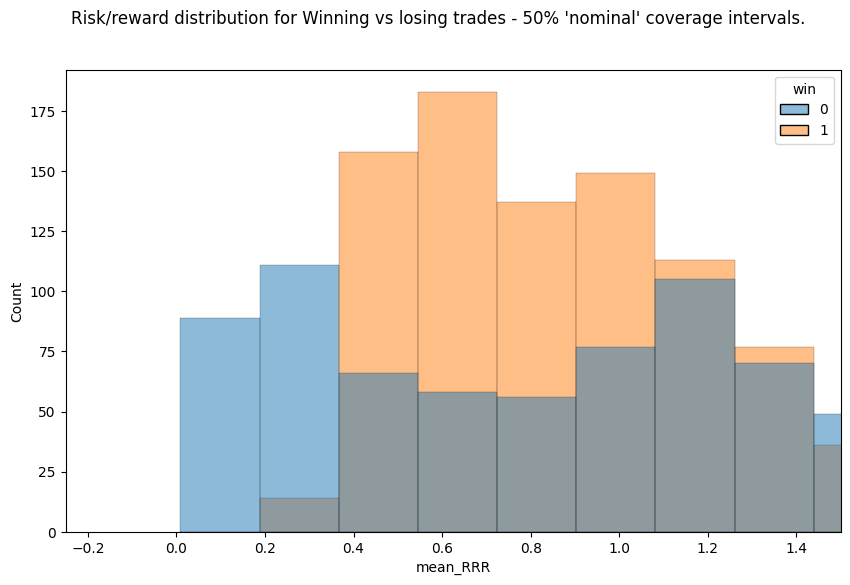

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Risk/reward distribution for Winning vs losing trades - 50% 'nominal' coverage intervals. ")

sns.histplot(data=backtest_35_pnl_rrr_filtered,
             x="mean_RRR",
             hue="win",
             ax=ax)

# Zoom into x-axis
ax.set_xlim(-0.25, 1.5)
plt.show()

The region between 0.4 and 1 seems to again have a higher frequency of wins than losses. 

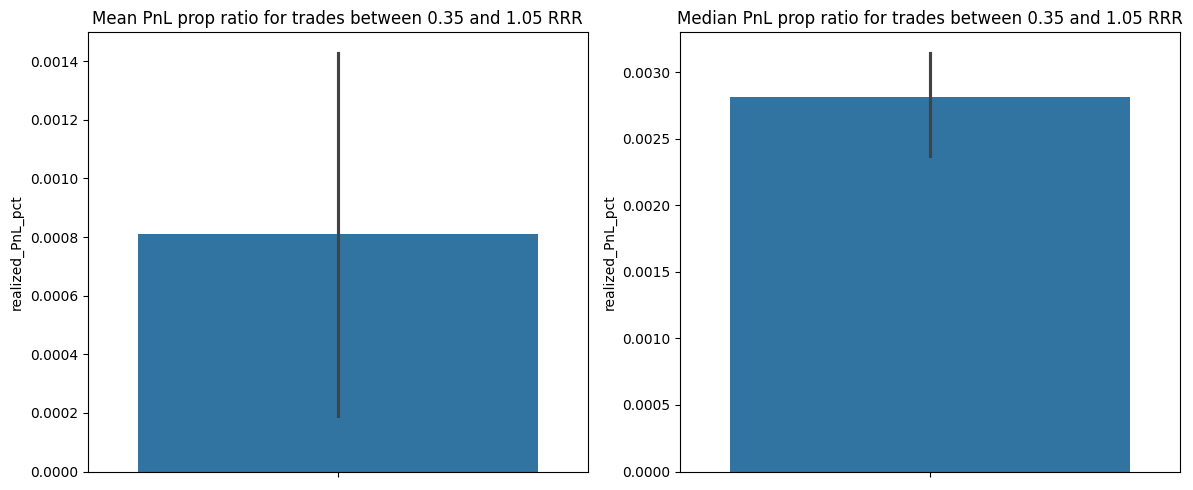

In [115]:
# Filter
backtest_35_pnl_rrr_between_0_35_and_1_05 = backtest_35_pnl_rrr.filter(pl.col("mean_RRR") >= 0.4, pl.col("mean_RRR") < 1.05)


# Plot
# ===============================================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean Risk/Reward ratio
axes[0].set_title("Mean PnL prop ratio for trades between 0.35 and 1.05 RRR")
sns.barplot(data=backtest_35_pnl_rrr_between_0_35_and_1_05, y="realized_PnL_pct", estimator="mean", ax=axes[0])
plot_bar_labels(axes[0]) 

# Median Risk/Reward ratio
axes[1].set_title("Median PnL prop ratio for trades between 0.35 and 1.05 RRR")
sns.barplot(data=backtest_35_pnl_rrr_between_0_35_and_1_05, y="realized_PnL_pct", estimator="median", ax=axes[1])
plot_bar_labels(axes[1])

plt.tight_layout()
plt.show()

Profitability of that no mans land is even lower than for the 50% nominal coverage.

Before trying the strategies derived from this strategies from the above analysis, let's look at something.

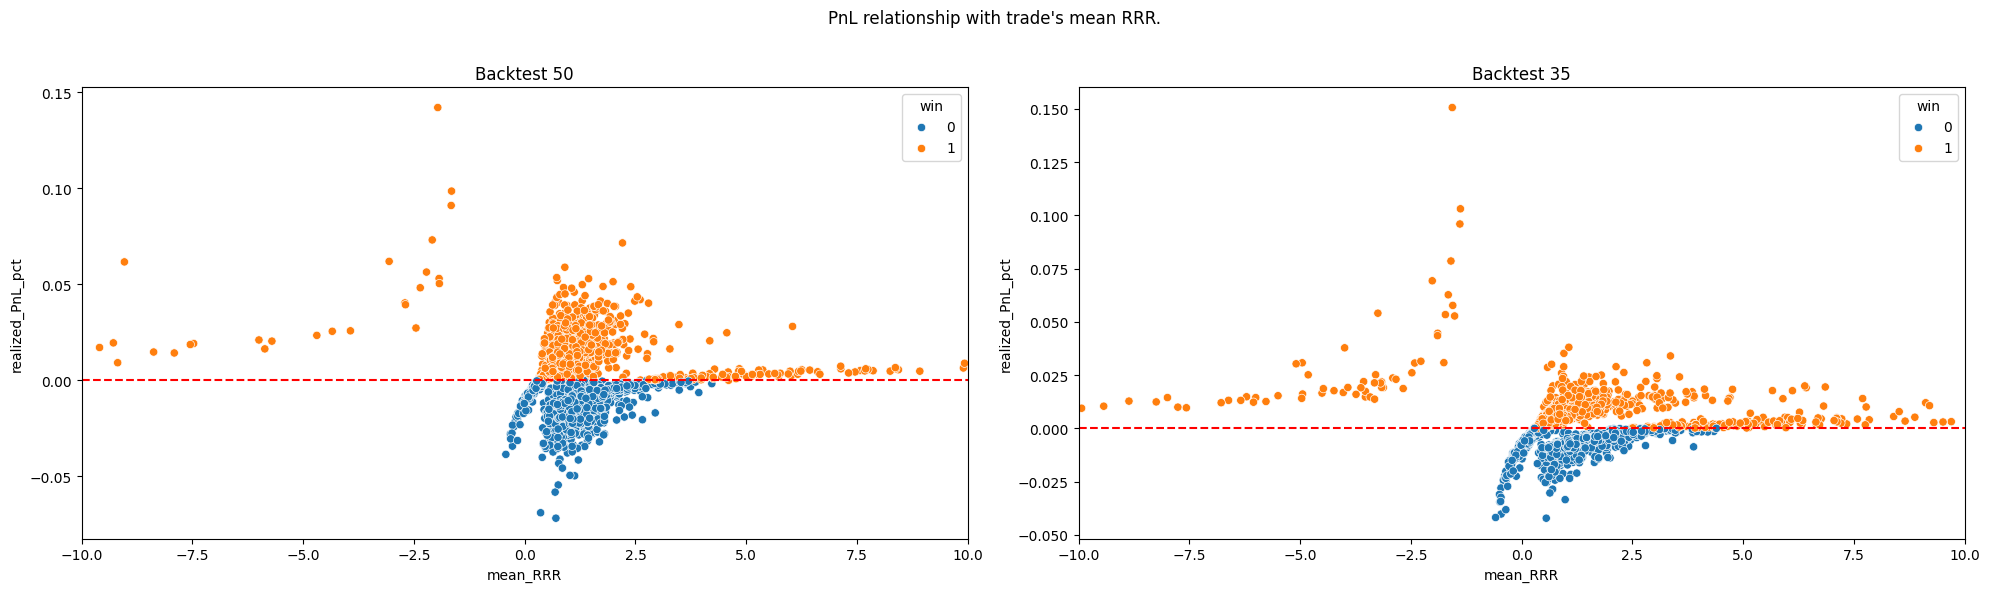

In [131]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 6), ncols=2)  #
fig.suptitle("PnL relationship with trade's mean RRR.")

# First scatter plot
sns.scatterplot(data=backtest_50_pnl_rrr,
                x="mean_RRR",
                y="realized_PnL_pct",
                hue="win",
                ax=ax1)

# Draw horizontal line at y=0
ax1.axhline(y=0, color="red", linestyle="--", linewidth=1.5)
# Zoom into x-axis
ax1.set_xlim(-10, 10)
ax1.set_title("Backtest 50")

# Second scatter plot
sns.scatterplot(data=backtest_35_pnl_rrr,
                x="mean_RRR",
                y="realized_PnL_pct",
                hue="win",
                ax=ax2)
# Draw horizontal line at y=0
ax2.axhline(y=0, color="red", linestyle="--", linewidth=1.5)
# Zoom into x-axis
ax2.set_xlim(-10, 10)
ax2.set_title("Backtest 35")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.subplots_adjust(top=0.85)  # Adjust the title position
plt.show()


There are very profitable trades that results in negative mean_RRR due to the lower bound of the coverage being lower than the first day's open price. The turning point seems to be around -1, because the open price cannot be bigger than itself. Also this happens more frequently with the 35% nominal coverage trades due to the interval being narrower.

In [145]:
trades_50_lower_neg_1 = backtest_50_pnl.filter(pl.col("mean_RRR") < -1)["trade_id"].unique().to_list()
trades_35_lower_neg_1 = backtest_35_pnl.filter(pl.col("mean_RRR") < -1)["trade_id"].unique().to_list()

calculate_outcome_n_end_price( backtest_predictions_bootstrap_35_analysis).filter(pl.col("trade_id").is_in(trades_35_lower_neg_1))

shape: (475, 13)
┌──────────────┬──────────────┬──────┬────────┬───┬────────────┬────────────┬─────────┬────────────┐
│ datetime     ┆ forecast_day ┆ week ┆ symbol ┆ … ┆ close      ┆ low        ┆ outcome ┆ end_price  │
│ ---          ┆ ---          ┆ ---  ┆ ---    ┆   ┆ ---        ┆ ---        ┆ ---     ┆ ---        │
│ datetime[ns] ┆ i64          ┆ i64  ┆ str    ┆   ┆ f64        ┆ f64        ┆ str     ┆ f64        │
╞══════════════╪══════════════╪══════╪════════╪═══╪════════════╪════════════╪═════════╪════════════╡
│ 2024-03-04   ┆ 1            ┆ 34   ┆ AAPL   ┆ … ┆ 174.468719 ┆ 173.16343  ┆ SL      ┆ 177.686618 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-03-05   ┆ 2            ┆ 34   ┆ AAPL   ┆ … ┆ 169.506653 ┆ 169.008456 ┆ SL      ┆ 176.924738 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-03-06   ┆ 3            ┆ 34   ┆ AAPL   ┆ … ┆ 168.510254 ┆ 168.071838 ┆ SL      ┆ 176.235918 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-03-07   ┆ 4            ┆ 34   ┆ AAPL   ┆ … ┆ 168.390686 ┆ 167.88253  ┆ SL      ┆ 175.943867 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-03-08   ┆ 5            ┆ 34   ┆ AAPL   ┆ … ┆ 170.114456 ┆ 168.330916 ┆ SL      ┆ 174.707021 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ …            ┆ …            ┆ …    ┆ …      ┆ … ┆ …          ┆ …          ┆ …       ┆ …          │
│ 2024-08-05   ┆ 1            ┆ 56   ┆ V      ┆ … ┆ 255.441147 ┆ 253.518656 ┆ SL      ┆ 263.70626  │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-08-06   ┆ 2            ┆ 56   ┆ V      ┆ … ┆ 257.254089 ┆ 254.773782 ┆ SL      ┆ 262.687228 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-08-07   ┆ 3            ┆ 56   ┆ V      ┆ … ┆ 255.520828 ┆ 255.311655 ┆ SL      ┆ 261.794525 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-08-08   ┆ 4            ┆ 56   ┆ V      ┆ … ┆ 258.817932 ┆ 256.915398 ┆ SL      ┆ 261.212835 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
│ 2024-08-09   ┆ 5            ┆ 56   ┆ V      ┆ … ┆ 259.26709  ┆ 258.518513 ┆ SL      ┆ 260.422427 │
│ 00:00:00     ┆              ┆      ┆        ┆   ┆            ┆            ┆         ┆            │
└──────────────┴──────────────┴──────┴────────┴───┴────────────┴────────────┴─────────┴────────────┘

Investigating the issue shows that in fact, those trades are not really profitable, but falsely flagged as profitable because they hit SL straight away, it being higher than the open price.

# 3. Trading simulations

For the above extracted heuristics, let's simulate the profitability of these trades:

In [44]:
weekly_trades_50, weekly_cash_flow_50 = backtest_strategy(backtest_predictions_df = backtest_predictions_bootstrap_50, 
                    ohlcv_data=  merged_df_with_tech_ind.select(["datetime","symbol","high","low","open","close"]),
                    top_operations = 10,
                    min_rr_ratio = 4,
                    wallet = 100000,
                    fraction_per_investment = 0.1,
                    commission_rate = 0.001,
                    verbose=True,
                    invest_max=True)

print("\nFinal strategy metrics:")
compute_all_metrics(weekly_cash_flow_50)

Week 1
Q symbols traded: 1
Total investment: 50000.0
Comission rate expenses: 50.0
Week_pnl: 255.32147386075138
Wallet: 100205.32147386075
Week 2
Q symbols traded: 1
Total investment: 50102.660736930375
Comission rate expenses: 50.102660736930375
Week_pnl: 505.7065497949986
Wallet: 100660.92536291882
Week 4
Q symbols traded: 1
Total investment: 50330.46268145941
Comission rate expenses: 50.33046268145941
Week_pnl: 0.12104316907802429
Wallet: 100610.71594340644
Week 10
Q symbols traded: 1
Total investment: 50305.35797170322
Comission rate expenses: 50.305357971703216
Week_pnl: 293.1816541849795
Wallet: 100853.59223961971
Week 13
Q symbols traded: 6
Total investment: 100853.59223961971
Comission rate expenses: 100.85359223961972
Week_pnl: 510.14632617824975
Wallet: 101262.88497355835
Week 18
Q symbols traded: 1
Total investment: 50631.442486779175
Comission rate expenses: 50.63144248677918
Week_pnl: 449.23903457922523
Wallet: 101661.4925656508
Week 21
Q symbols traded: 4
Total investment

{'Equity Final [$]': 109580.59146656076,
 'Return [%]': 8.8611008407516,
 'Return (Ann.) [%]': 13.444208512650091,
 'Volatility (Ann.) [%]': 1.3327010711560179,
 'Sharpe Ratio': 10.087940051693852,
 'Sortino Ratio': 30.211541499017805,
 'Max. Drawdown [%]': -0.13715190264436558,
 'Avg. Drawdown [%]': -0.005195323728543621,
 'Max. Drawdown Duration [weeks]': 21,
 'Avg. Drawdown Duration [weeks]': 9.0,
 '# Trades': 78,
 'Win Rate [%]': 43.58974358974359,
 'Best Trade [%]': 0.73664764673119,
 'Worst Trade [%]': -0.08715190264435968,
 'Avg. Trade [%]': 0.32603217152263103,
 'Profit Factor': 131.9337565452519,
 'Expectancy [%]': 0.32603217152263103}

In [68]:
weekly_trades_35, weekly_cash_flow_35 = backtest_strategy(backtest_predictions_df = backtest_predictions_bootstrap_35, 
                    ohlcv_data=  merged_df_with_tech_ind.select(["datetime","symbol","high","low","open","close"]),
                    top_operations = 5,
                    min_rr_ratio = 5,
                    wallet = 100000,
                    fraction_per_investment = 0.2,
                    commission_rate = 0.00,
                    verbose=True,
                    invest_max=True)

print("\nFinal strategy metrics:")
metrics_35 = compute_all_metrics(weekly_cash_flow_35)
metrics_35

Week 0
Q symbols traded: 2
Total investment: 100000.0
Comission rate expenses: 0.0
Week_pnl: 235.45483042891283
Wallet: 100235.4548304289
Week 1
Q symbols traded: 1
Total investment: 50117.72741521445
Comission rate expenses: 0.0
Week_pnl: 150.09777382891255
Wallet: 100385.55260425781
Week 2
Q symbols traded: 1
Total investment: 50192.77630212891
Comission rate expenses: 0.0
Week_pnl: 246.93512690163465
Wallet: 100632.48773115945
Week 3
Q symbols traded: 1
Total investment: 50316.24386557972
Comission rate expenses: 0.0
Week_pnl: 328.0572035758283
Wallet: 100960.54493473527
Week 4
Q symbols traded: 2
Total investment: 100960.54493473527
Comission rate expenses: 0.0
Week_pnl: 496.23252535466025
Wallet: 101456.77746008993
Week 5
Q symbols traded: 1
Total investment: 50728.388730044964
Comission rate expenses: 0.0
Week_pnl: 201.45690148196388
Wallet: 101658.23436157189
Week 9
Q symbols traded: 1
Total investment: 50829.11718078594
Comission rate expenses: 0.0
Week_pnl: 146.83800547160487


{'Equity Final [$]': 119291.34201372159,
 'Return [%]': 18.83317760275187,
 'Return (Ann.) [%]': 17.719985207378073,
 'Volatility (Ann.) [%]': 1.1746694617085647,
 'Sharpe Ratio': 15.08508204648841,
 'Sortino Ratio': None,
 'Max. Drawdown [%]': 0.0,
 'Avg. Drawdown [%]': 0.0,
 'Max. Drawdown Duration [weeks]': 55,
 'Avg. Drawdown Duration [weeks]': 28.0,
 '# Trades': 109,
 'Win Rate [%]': 50.45871559633027,
 'Best Trade [%]': 0.7504664551759791,
 'Worst Trade [%]': 0.006861346463971599,
 'Avg. Trade [%]': 0.3170796848495175,
 'Profit Factor': None,
 'Expectancy [%]': 0.3170796848495175}

In [77]:
buy_hold_stock_performance_metrics(ticker="^GSPC", start="2023-07-17", end="2025-01-17")[1]

{'Return [%]': 28.22388845304613,
 'Volatility': 78.68630989410671,
 'Sharpe ratio': 0.08754250098461762,
 'Sortino ratio': 0.11902876232876745,
 'Max drawdown [%]': -10.828200090705042,
 'Max drawdown duration [weeks]': 61}

In [73]:
plot_strategy_vs_ticker(strategy_df=weekly_cash_flow_35 , ticker="^GSPC", metrics=metrics_35)